# Predicting the functionality of Vibration Dampers for Cars

The following code was created in cooperation with the FSD GmbH in 2022. 
During the general inspection a car has to pass a crossing threshold while a motion sensor inside the car captures both the deflection and acceleration data in all 3 space dimensions. Based on the recorded data the inspector will evaluate the functionality of both front and rear vibration dampers.

The goal was to automate this evaluation process by training a neural net on the provided dataset. For the sake of simplicity we only consider the spacial deflection data. 

In [1]:
import numpy as np
import pandas as pd
#%pip install tensorflow
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Important!!!!!!!!!!
The original data is under a non-disclosure agreement and was stored in HDF-5-files and then read to pandas Dataframes. Thus this github-repository is not using the original data and only meant to showcase the process and applied techniques.

To emulate the data we construct random DataFrames of the same format. 

In [2]:
def createArtificialRandomTrainingData(size): 
    t = np.linspace(0,2,100)
    list_of_dfs, labels = [], []
    for _ in itertools.repeat(None,size):
        x = np.abs(np.cumsum(np.random.randn(100)))
        y = np.abs(np.cumsum(np.random.randn(100)))
        z = np.abs(np.cumsum(np.random.randn(100)))
        list_of_dfs.append(pd.DataFrame({'Time':t, 'ax': x, 'ay': y, 'az': z}))
        label = pd.DataFrame({'Label': np.random.randint(0,2)}, index = [0])
        labels.append(label)
    return list_of_dfs, labels
x_trainPre, y_trainPre = createArtificialRandomTrainingData(10000)

We start by plotting one example of a functioning vibration damper (label = 1) and one of a broken damper (label = 0).

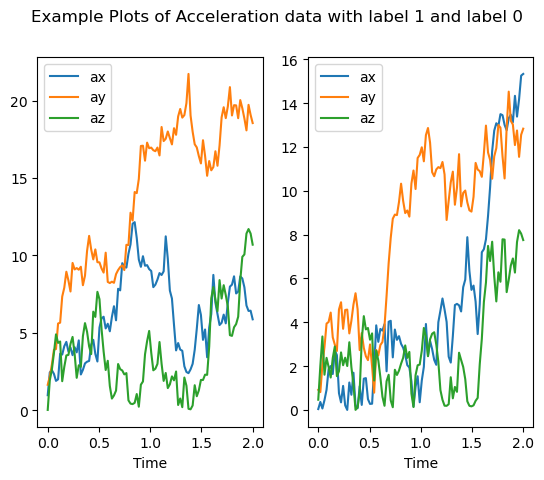

In [3]:
yNumpy = [df.loc[0,'Label'] for df in y_trainPre]
idx1, idx2 = yNumpy.index(1), yNumpy.index(0)

fig, (ax0,ax1) = plt.subplots(1,2)
fig.suptitle('Example Plots of Acceleration data with label 1 and label 0')

x_trainPre[idx1].plot(x = 'Time', y = ['ax', 'ay','az'],kind='line', ax = ax0)
x_trainPre[idx2].plot(x = 'Time', y = ['ax', 'ay','az'],kind='line', ax = ax1)
plt.show()


We start preprocessing the data by removing all nan-values. If a dataframe contains more than 5 nan-values in a single column we remove it. Otherwise we replace all the missing values by the mean of corresponding column.

Next we check that all labels are binary and remove them if necessary.

In [4]:
# clean data
# remove all nan-values and replace by mean
for idx,df in enumerate(x_trainPre):
    count = df[['ax','ay','az']].isna().sum().to_numpy()
    if(any(i > 5 for i in count)):
        x_trainPre.remove(df)
        y_trainPre.pop(idx)
    for idx,counter in enumerate(count):
        if(counter):
            mean = df.iloc[:,idx + 1].mean()
            df.iloc[:, idx + 1] = df.iloc[:, idx + 1 ].replace(np.nan, mean)
# check if all labels are binary
for idx,df in enumerate(y_trainPre):
    if (df[['Label']].to_numpy() not in [[0],[1]]):
        y_trainPre.remove(df)
        x_trainPre.pop(idx)      

To simplify some of the following preprocessing steps, we transform the data into a multidimensional numpy array.

In [5]:
# bring data into correct format
x_train_numpy = np.empty([10000,3,100])
y_train_numpy = np.empty([10000,1])
for idx, df in enumerate(x_trainPre):
    x_train_numpy[idx,:,:] = df[['ax','ay','az']].transpose().to_numpy()
for idx, df in enumerate(y_trainPre):
    y_train_numpy[idx,:] = df[['Label']].to_numpy()

Since our data has strongly varying deflection values, we now want to normalise all entries in our data matrices into the interval (0,1) by using a MinMaxScaler. This will speed up the training process and potentially improve performance. Since Python doesn't provide a MinMaxScaler for 3-dimensional training data, we use a class that extends the provided scaler.

In [6]:
# scale all values into (0,1)
class MinMaxScaler3D(MinMaxScaler):
    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)

scaler = MinMaxScaler3D()
x_trainScaledNumpy = scaler.fit_transform(x_train_numpy)

Another interesting approach to data preprocessing is a wavelet transformation. It works very similar to the well-known Fast-Fourier transform and reduces the number of features by "smoothening" the data.
As an example we apply a wavelet transformation of type 'sym5' and degree 3 and save the transformed data in order to use it for training later.

In [7]:
waveletxData = np.empty([10000, 3, 20])
for idx,array in enumerate(x_train_numpy):
    ax_data = array[0]
    ay_data = array[1]
    az_data = array[2]
    for _ in itertools.repeat(None,3):
        (ax_data, coef) = pywt.dwt(ax_data, 'sym5')
        (ay_data, coef) = pywt.dwt(ay_data, 'sym5')
        (az_data, coef) = pywt.dwt(az_data, 'sym5')
    waveletxData[idx,:,:] = ax_data, ay_data,az_data

We will visualize the difference between raw and wavelet-transformed data by plotting both version for the first space dimension.

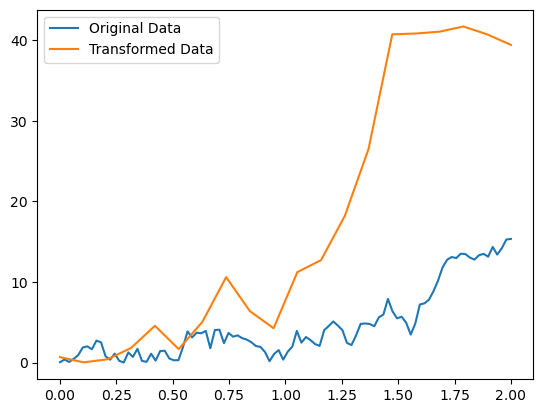

In [8]:
fig, ax = plt.subplots()
line1, = ax.plot(np.linspace(0,2,100), x_train_numpy[0,0], label = 'Original Data')
line2, = ax.plot(np.linspace(0,2,20), waveletxData[0,0], label = 'Transformed Data')
plt.legend(handles = [line1, line2])
plt.show()

We split the data into training and test data, once for the raw data, once for the normalized data and once for the wavelet-transformed data, so we can evaluate our models performance accordingly. In order to achieve comparability we fix the random state.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_train_numpy, y_train_numpy, test_size = 0.1,
                                                    random_state = 42)
x_trainNormalized, x_testNormalized, y_train, y_test = train_test_split(x_trainScaledNumpy, y_train_numpy, 
                                                                        test_size = 0.1, 
                                                                        random_state = 42 )
x_trainWavelet, x_testWavelet, y_train, y_test = train_test_split(waveletxData, y_train_numpy, test_size = 0.1, 
                                                                  random_state = 42)

The following code block initializes 3 different type of models used to predict the functionality of the vibration dampers. Keep in mind the wavelet transformed data cannot be fed into these models because of the feature reduction we performed earlier.
We test a fully connected model, an LSTM model and a CNN model. Obviously the network's architecture can be varied trivially.

In [10]:
# build a simple fully-connected model

modelDense = tf.keras.models.Sequential([
    tf.keras.Input(shape = (3,100,)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation = 'relu', name = 'firstLayer'),
    tf.keras.layers.Dense(10, activation = 'tanh'),
    tf.keras.layers.Dense(1)
])
modelDenseWavelet = tf.keras.models.Sequential([
    tf.keras.Input(shape = (3,20,)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(15, activation = 'relu', name = 'firstLayer'),
    tf.keras.layers.Dense(10, activation = 'tanh'),
    tf.keras.layers.Dense(1)
])
modelLSTM = tf.keras.models.Sequential([
    tf.keras.Input(shape = (3,100,)),
    tf.keras.layers.LSTM(units = 128, return_sequences=True, activation = 'relu'),
    tf.keras.layers.LSTM(units = 64, activation = 'tanh'),
    tf.keras.layers.Dense(1)
])

modelCNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(12,3, activation = 'tanh', input_shape = (3,100,)),
    tf.keras.layers.AveragePooling1D(1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
    
    
])


# save initial random weights in order to reset the model later
weightsDense, weightsLSTM = modelDense.get_weights(), modelLSTM.get_weights()

# compile model
modelDense.compile(optimizer = 'SGD', loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                   metrics = ['accuracy'])
modelDenseWavelet.compile(optimizer = 'SGD', loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                   metrics = ['accuracy'])
modelLSTM.compile(optimizer = 'SGD', loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                   metrics = ['accuracy'])
modelCNN.compile(optimizer = 'SGD', loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                   metrics = ['accuracy'])

C:\Users\passi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


We start by using the built-in fit function to train the model. Other custom training functions have been tested in the process of refining the model but have been found not to have any significant impact on accuracy or training speed.

In [11]:
# train model
historyRawDense = modelDense.fit(x_train, y_train, epochs = 1000, batch_size = 256, verbose = 0)
performanceUnnormalizedDense = modelDense.evaluate(x_test, y_test, verbose = 0)[1]

We visualize both the loss and accuracy history of the training process.

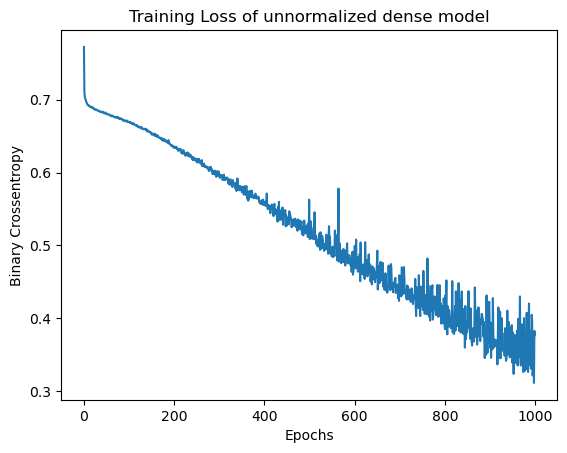

Text(0.5, 1.0, 'Training Accuracy of unnormalized dense model')

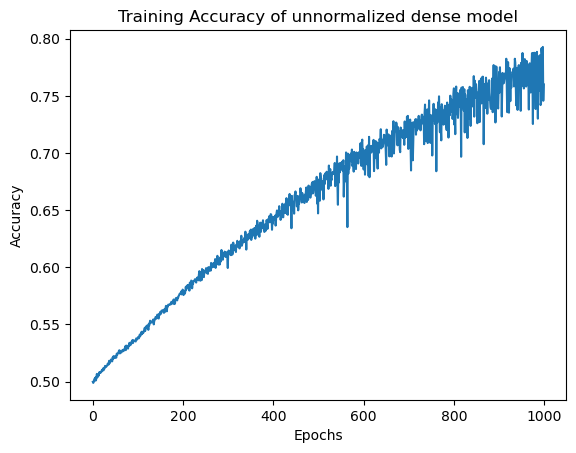

In [12]:
plt.plot(historyRawDense.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.title('Training Loss of unnormalized dense model')
plt.show()
plt.plot(historyRawDense.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy of unnormalized dense model')

In comparison we want to train the same model on the normalized data. To ensure a fair comparison we first reset the weights to the initial state.

In [13]:
# reset model weights
modelDense.set_weights(weightsDense)
historyNormalizedDense = modelDense.fit(x_trainNormalized, y_train, epochs = 1000, batch_size = 256, verbose = 0)
performanceNormalizedDense = modelDense.evaluate(x_testNormalized, y_test, verbose = 0)[1]

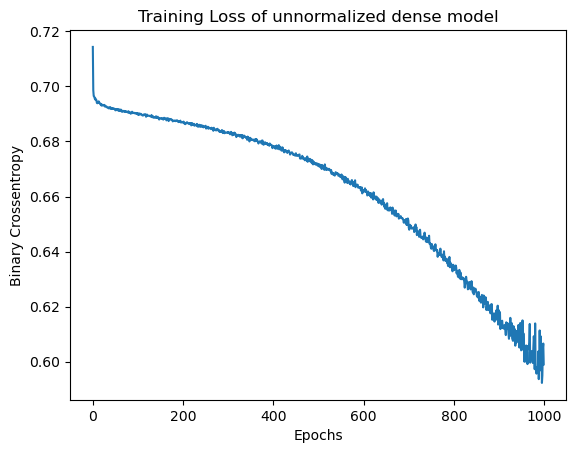

Text(0.5, 1.0, 'Training Accuracy of unnormalized dense model')

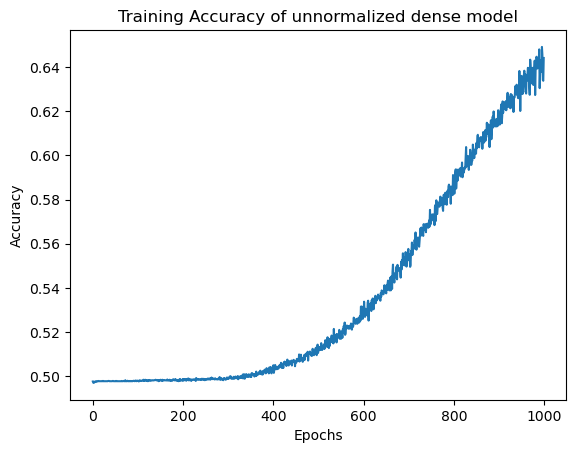

In [14]:
plt.plot(historyNormalizedDense.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.title('Training Loss of unnormalized dense model')
plt.show()
plt.plot(historyNormalizedDense.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy of unnormalized dense model')

We will now perform the same training for the LSTM and then the CNN model.

In [15]:
historyRawLSTM = modelLSTM.fit(x_train, y_train, epochs = 1000, verbose = 0, batch_size = 128)
performanceRawLSTM = modelLSTM.evaluate(x_test, y_test, verbose = 0)[1]

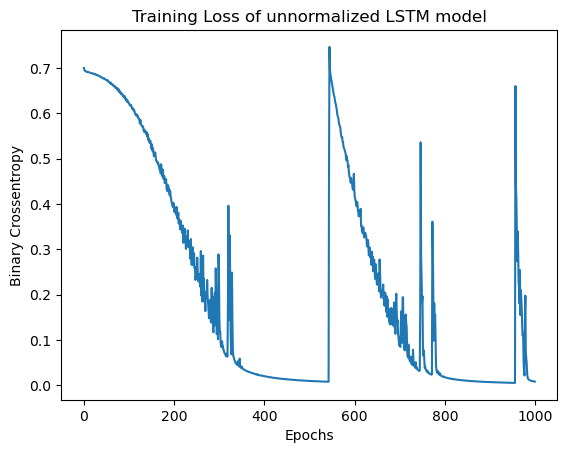

Text(0.5, 1.0, 'Training Accuracy of unnormalized LSTM model')

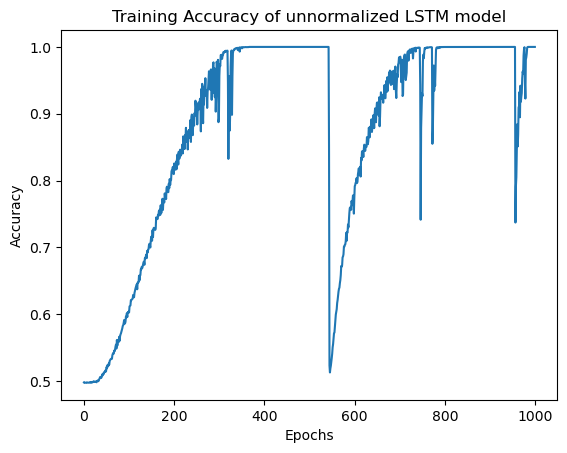

In [16]:
plt.plot(historyRawLSTM.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.title('Training Loss of unnormalized LSTM model')
plt.show()
plt.plot(historyRawLSTM.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy of unnormalized LSTM model')

In [17]:
modelLSTM.set_weights(weightsLSTM)
historyNormalizedLSTM = modelLSTM.fit(x_trainNormalized, y_train, epochs = 1000, verbose = 0, batch_size = 128)
performanceNormalizedLSTM = modelLSTM.evaluate(x_test, y_test, verbose = 0)[1]

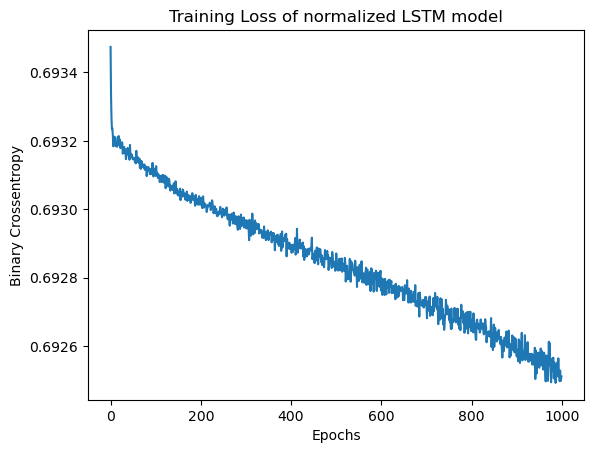

Text(0.5, 1.0, 'Training Accuracy of normalized LSTM model')

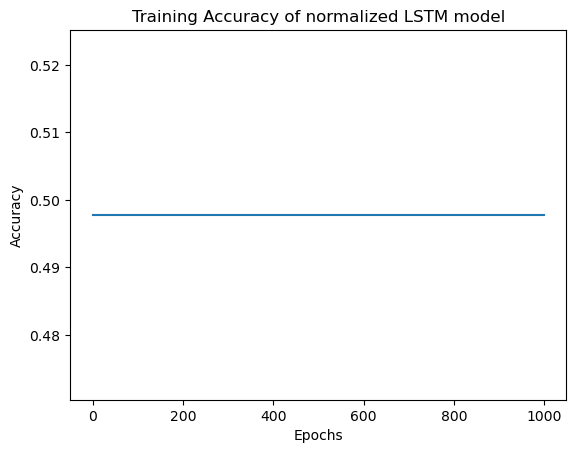

In [18]:
plt.plot(historyNormalizedLSTM.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.title('Training Loss of normalized LSTM model')
plt.show()
plt.plot(historyNormalizedLSTM.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy of normalized LSTM model')

In [19]:
historyCNNRaw = modelCNN.fit(x_train,y_train, epochs = 1000, verbose = 0)
performanceCNNRaw = modelCNN.evaluate(x_test, y_test, verbose = 0)[1]

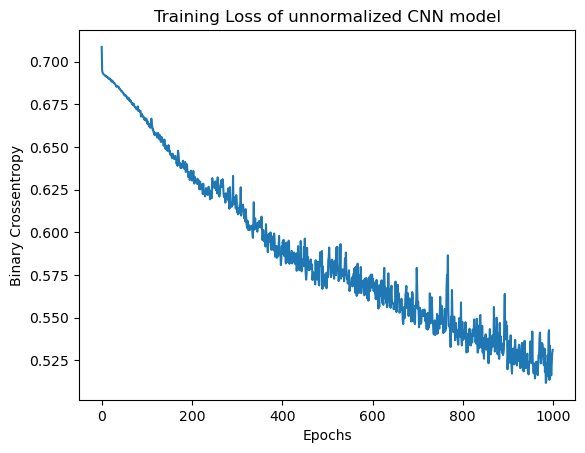

Text(0.5, 1.0, 'Training Accuracy of unnormalized CNN model')

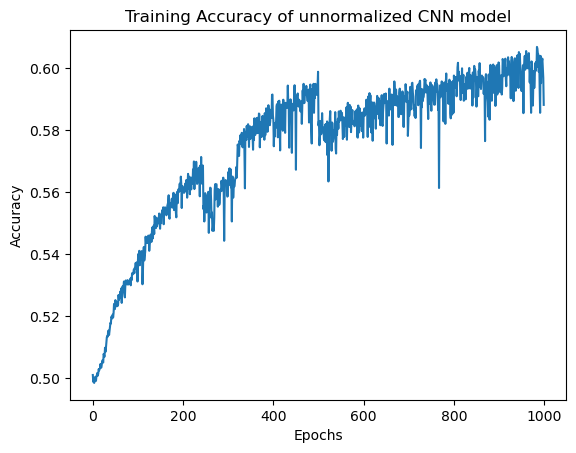

In [20]:
plt.plot(historyCNNRaw.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.title('Training Loss of unnormalized CNN model')
plt.show()
plt.plot(historyCNNRaw.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy of unnormalized CNN model')

[0.492000013589859, 0.5109999775886536]


(0.0, 1.0)

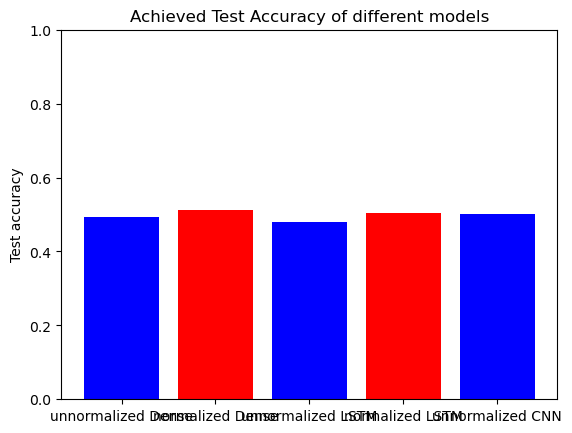

In [21]:
fig, ax = plt.subplots()
print([performanceUnnormalizedDense, performanceNormalizedDense])
ax.bar(['unnormalized Dense', 'normalized Dense','unnormalized LSTM','normalized LSTM', 'unnormalized CNN'], 
       [performanceUnnormalizedDense, performanceNormalizedDense, performanceRawLSTM, 
        performanceNormalizedLSTM, performanceCNNRaw],
       color = ['blue', 'red','blue','red', 'blue'])
ax.set_ylabel('Test accuracy')
ax.set_title('Achieved Test Accuracy of different models')
ax.set_ylim(0,1)

Using the actual data we observed that the normalized CNN model outperformed all other models by a big margin (up to 97% accuracy). The standard fully connected model performed the worst while the LSTM model achieved an average 85% accuracy.